## Initialization

In [1]:
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
from pyomo.core import Var
import pyomo.environ as en
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
EXEC_PATH = "C:\opt\ibm\ILOG\CPLEX_Studio2211\cplex\bin\x64_win64\cplex.exe"

## Data

In [3]:
#data
data = pd.read_excel('Dados_DEEC_Scenarios.xlsx', None)
i = len(data['EV_Data']['EV'].tolist())
t = len(data['Building']['t'].tolist())
delta_t = 0.25
P_build = data['Building']['Building_Load'].tolist()
P_plus = data['Building']['P_plus'].tolist()
P_minus = data['Building']['P_minus'].tolist()
P_ch_max = 10
P_dch_max = 10
C_grid = data['Building']['C_grid'].tolist()
C_grid_exp = data['Building']['C_grid_exp'].tolist()
C_buy = data['Building']['C_buy'].tolist()
C_sell = data['Building']['C_sell'].tolist()
T_arv = data['EV_Data']['T_arv'].tolist()
T_dep = data['EV_Data']['T_dep'].tolist()
E_ev_bat = 30
Soc_arv = data['EV_Data']['Soc_arv'].tolist()
Soc_dep = data['EV_Data']['Soc_dep'].tolist()
Soc_max = 1
Soc_min = 0.2

# Scenario calculation

In [4]:
def optimization(i=i, t=t, delta_t=delta_t, P_build=P_build, P_plus=P_plus, P_minus=P_minus, P_ch_max=P_ch_max, P_dch_max=P_dch_max, C_grid= C_grid, C_grid_exp=C_grid_exp, C_buy=C_buy, C_sell=C_sell, T_arv=T_arv, T_dep=T_dep, E_ev_bat=E_ev_bat, Soc_arv=Soc_arv, Soc_dep=Soc_dep, Soc_max=Soc_max, Soc_min=Soc_min):
    model = pyo.ConcreteModel()
    
    #Sets
    model.I = pyo.RangeSet(i) #index of the vehicles i parked
    model.T = pyo.RangeSet(t) #index of the time periods (min)

    #Parameters
    model.delta_t = pyo.Param(initialize=delta_t)
    model.P_build = pyo.Param(model.T, initialize=lambda model, t: P_build[t-1])
    model.P_plus = pyo.Param(model.T, initialize=lambda model, t: P_plus[t-1])
    model.P_minus = pyo.Param(model.T, initialize=lambda model, t: P_minus[t-1])
    model.P_ch_max = pyo.Param(initialize=P_ch_max)
    model.P_dch_max = pyo.Param(initialize=P_dch_max)
    model.C_grid = pyo.Param(model.T, initialize=lambda model, t: C_grid[t-1])
    model.C_grid_exp = pyo.Param(model.T, initialize=lambda model, t: C_grid_exp[t-1])
    model.C_buy = pyo.Param(model.T, initialize=lambda model, t: C_buy[t-1])
    model.C_sell = pyo.Param(model.T, initialize=lambda model, t: C_sell[t-1])
    model.T_arv = pyo.Param(model.I, initialize=lambda model, i: T_arv[i-1])
    model.T_dep = pyo.Param(model.I, initialize=lambda model, i: T_dep[i-1])
    model.E_ev_bat = pyo.Param(initialize=E_ev_bat)
    model.Soc_arv = pyo.Param(model.I, initialize=lambda model, i: Soc_arv[i-1])
    model.Soc_dep = pyo.Param(model.I, initialize=lambda model, i: Soc_dep[i-1])
    model.Soc_max = pyo.Param(initialize=Soc_max)
    model.Soc_min = pyo.Param(initialize=Soc_min)

    #Variables
    #Binary variables
    model.x = pyo.Var(model.I, model.T, domain=pyo.Binary)
    model.y = pyo.Var(model.I, model.T, domain=pyo.Binary)

    #Non-binary variables
    model.alpha = pyo.Var(model.T, domain=pyo.NonNegativeReals)
    model.beta = pyo.Var(model.T, domain=pyo.NonNegativeReals)
    model.ch = pyo.Var(model.T, domain=pyo.NonNegativeReals)
    model.dch = pyo.Var(model.T, domain=pyo.NonNegativeReals)
    model.e_ev = pyo.Var(model.I, model.T, domain=pyo.NonNegativeReals)
    model.p_ev_ch = pyo.Var(model.I, model.T, domain=pyo.NonNegativeReals)
    model.p_ev_dch = pyo.Var(model.I, model.T, domain=pyo.NonNegativeReals)

    #Constraints
    model.constraints = pyo.ConstraintList()

    #Constraint 1
    #for i in model.I:
    for t in range(model.T_arv[i], model.T_dep[i]):
        model.constraints.add(sum(model.x[i,t] for i in model.I) + sum(model.y[i,t] for i in model.I) <= 1)
            #model.constraints.add(model.x[i,t] + model.y[i,t] <= 1)

    for i in model.I:
        for t in range(1, model.T_arv[i]):
            model.constraints.add(model.x[i,t] + model.y[i,t] == 0)

    for i in model.I:
        for t in range(model.T_dep[i]+1,97):
            model.constraints.add(model.x[i,t] + model.y[i,t] == 0)

    #Constraint 2
    for i in model.I:
        for t in range(model.T_arv[i],model.T_dep[i]):
            model.constraints.add(model.e_ev[i,t] == model.e_ev[i,t-1] + (model.delta_t * (model.p_ev_ch[i,t] * model.x[i,t])) - (model.delta_t * (model.p_ev_dch[i,t] * model.y[i,t])))

    #Constraint 3
    for i in model.I:
        for t in range(model.T_dep[i],97):
            model.constraints.add(model.e_ev[i,t] >= model.Soc_dep[i] * model.E_ev_bat)

    #Constraint 4
    for i in model.I:
        for t in range(1,model.T_arv[i]):
            model.constraints.add(model.e_ev[i,t] == model.Soc_arv[i] * model.E_ev_bat)

    #Constraint 5
    for i in model.I:
        for t in model.T:
            model.constraints.add(model.E_ev_bat * model.Soc_arv[i] <= model.e_ev[i,t])
            model.constraints.add(model.e_ev[i,t] <= model.Soc_max * model.E_ev_bat)

    #Constraint 6
    for i in model.I:
        for t in range(model.T_arv[i], model.T_dep[i]):
            model.constraints.add(model.p_ev_ch[i,t] <= model.P_ch_max)
        

    #Constraint 7
    for i in model.I:
        for t in range(model.T_arv[i], model.T_dep[i]):
            model.constraints.add(model.p_ev_dch[i,t] <= model.P_dch_max)
    
    #Constraint 6
    for t in model.T:
        model.constraints.add(model.alpha[t] == model.delta_t * sum(model.p_ev_ch[i,t] * model.x[i,t] for i in model.I))

    #Constraint 7
    for t in model.T:
        model.constraints.add(model.beta[t] == model.delta_t * sum(model.p_ev_dch[i,t] * model.y[i,t] for i in model.I))
    
    #Constraint 11
    for t in model.T:
        model.constraints.add(model.alpha[t] * model.beta[t] == 0)
        model.constraints.add(sum(model.x[i,t] for i in model.I) * sum(model.y[i,t] for i in model.I) == 0)
    
    #Constraint 8
    for t in range(2,97):
        model.constraints.add(model.ch[t] == model.ch[t-1] + model.alpha[t])
    model.constraints.add(model.ch[1] == 0)
    
    #Constraint 9
    for t in range(2,97):
        model.constraints.add(model.dch[t] == model.dch[t-1] + model.beta[t])
    model.constraints.add(model.dch[1] == 0)

    #constraint 10
    model.constraints.add(sum(model.dch[t] for t in model.T) <= sum(model.ch[t] for t in model.T))

    #Objective Function
    def rule_obj(mod):
        return sum(((mod.P_plus[t] - mod.alpha[t]) * mod.C_grid[t]) - ((mod.P_minus[t] - mod.beta[t]) * mod.C_grid_exp[t]) + (mod.C_sell[t] * mod.beta[t]) - (mod.C_buy[t] * mod.alpha[t]) for t in mod.T)
        #return sum(((mod.P_plus[t] - mod.alpha[t]) * mod.C_grid[t]) - ((mod.P_minus[t] - mod.beta[t]) * mod.C_grid_exp[t]) + (mod.C_buy[t] * mod.alpha[t]) - (mod.C_sell[t] * mod.beta[t]) for t in mod.T)
        #return sum(((mod.P_plus[t] + mod.alpha[t] - mod.beta[t]) * mod.C_grid[t]) - ((mod.P_minus[t] - mod.alpha[t]) * mod.C_grid_exp[t]) + (mod.C_sell[t] * mod.beta[t]) - (mod.C_buy[t] * mod.alpha[t]) for t in mod.T)
        #return sum(((mod.P_plus[t] + mod.alpha[t] - mod.beta[t]) * mod.C_grid[t]) - ((mod.P_minus[t] - mod.alpha[t] + mod.beta[t]) * mod.C_grid_exp[t]) + (mod.C_sell[t] * mod.beta[t]) - (mod.C_buy[t] * mod.alpha[t]) for t in mod.T)
    model.obj = pyo.Objective(rule = rule_obj, sense = pyo.minimize)

    #Solver
    # Create a solver instance and set executable path
    opt = pyo.SolverFactory('gurobi')
    #opt.options['timelimit']=60
    # Solve the model
    results = opt.solve(model, tee=True)
    # Print solution status
    print(model.obj())

    return model

In [5]:
data2 = pd.read_excel('Dados_DEEC_V8_Case_6.xlsx', None)
i_20 = len(data2['EV_Data']['EV'].tolist())
T_arv_20 = data2['EV_Data']['T_arv'].tolist()
T_dep_20 = data2['EV_Data']['T_dep'].tolist()
Soc_arv_20 = data2['EV_Data']['Soc_arv'].tolist()
Soc_dep_20 = data2['EV_Data']['Soc_dep'].tolist()


In [6]:
#model=optimization(i=i_20, T_arv=T_arv_20, T_dep=T_dep_20, Soc_arv=Soc_arv_20, Soc_dep=Soc_dep_20)
model=optimization()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-07-20
Read LP format model from file C:\Users\almei\AppData\Local\Temp\tmpoef29wk5.pyomo.lp
Reading time = 0.02 seconds
x1: 4049 rows, 5185 columns, 5856 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i7-1195G7 @ 2.90GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4049 rows, 5185 columns and 5856 nonzeros
Model fingerprint: 0x5a64e47c
Model has 592 quadratic constraints
Variable types: 3265 continuous, 1920 integer (1920 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [3e-01, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [9e-02, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+01]
Presolve removed 3472 rows and 3938 columns
Presolve time: 0.01s
Presolved: 2181 rows, 1723 columns, 

In [7]:

# Calculate the number of rows and columns in the matrices
num_rows = len(model.I)
num_cols = len(model.T)

# Initialize empty matrices for X and Y
X_values_matrix = np.empty((num_rows, num_cols))
Y_values_matrix = np.empty((num_rows, num_cols))
total_charging_values = np.empty((num_cols))
total_discharging_values = np.empty((num_cols))
C_values_matrix = np.empty((num_cols))
D_values_matrix = np.empty((num_cols))

# Fill the matrices with values
for i, i_value in enumerate(model.I):
    for t, t_value in enumerate(model.T):
        X_values_matrix[i, t] = pyo.value(model.x[i_value, t_value])
        Y_values_matrix[i, t] = pyo.value(model.y[i_value, t_value])

for t, t_value in enumerate(model.T):
    total_charging_values [t] = pyo.value(model.alpha[t_value])
    total_discharging_values [t] = pyo.value(model.beta[t_value])
    C_values_matrix[t] = pyo.value(model.ch[t_value])
    D_values_matrix[t] = pyo.value(model.dch[t_value])

# Graphics plotting

In [8]:
def plot_energy_levels(e_values, model):
    plt.figure(figsize=(10, 5))
    for i in model.I:
        plt.plot(model.T, e_values[i-1], label=f'Car {i}')
    plt.xlabel('Time [hour]')
    plt.ylabel('SOC [%]')
    plt.title('Energy Levels of Cars')
    plt.legend()
    plt.grid(True)
    plt.xticks(np.arange(1, 97, 4), labels=np.arange(1, 25))
    plt.show()

def plot_total_power(model, P_build):
    plt.figure(figsize=(10, 5))
    charging_discharging_power = (np.array([model.alpha[t].value for t in model.T]) - np.array([model.beta[t].value for t in model.T])) * 4
    #charging_power = np.array([model.alpha[t].value for t in model.T]) * 4
    #discharging_power = np.array([model.beta[t].value for t in model.T]) * (-4)
    plt.plot(P_build, label='Building liquid Net Load')
    plt.plot(charging_discharging_power, label='Charging and discharging profile')
    #plt.plot(charging_power, label='Charging profile')
    #plt.plot(discharging_power, label='Discharging profile')
    plt.xlabel('Time [hour]')
    plt.ylabel('Load [kW]')
    plt.title('Building vs EV Loads')
    plt.grid(True)
    plt.xticks(np.arange(1, 97, 4), labels=np.arange(1, 25))
    plt.legend()
    plt.show()

def plot_net_load(model, P_build):
    plt.figure(figsize=(10, 5))
    charging_discharging_power = (np.array([model.alpha[t].value for t in model.T]) - np.array([model.beta[t].value for t in model.T])) * 4
    Net_load = P_build + charging_discharging_power
    plt.plot(P_build, label='Net Load (No EVs)')
    plt.plot(Net_load, label='Net Load (EVs)')
    plt.xlabel('Time [hour]')
    plt.ylabel('Load [kW]')
    plt.title('Building vs EV Loads')
    plt.grid(True)
    plt.xticks(np.arange(1, 97, 4), labels=np.arange(1, 25))
    plt.legend()
    plt.show()

def plot_load_and_price(model, P_build, C_grid, C_grid_exp):
    plt.figure(figsize=(10, 5))
    charging_discharging_power = (np.array([model.alpha[t].value for t in model.T]) - np.array([model.beta[t].value for t in model.T])) * 4
    Net_load = P_build + charging_discharging_power
    plt.plot(P_build, label='Net Load (No EVs)')
    plt.plot(Net_load, label='Net Load (EVs)')
    plt.xlabel('Time [hour]')
    plt.ylabel('Load [kW]')
    plt.title('Building vs EV Loads')
    plt.grid(True)

    ax2 = plt.gca().twinx()
    ax2.plot(C_grid, label='Grid import', color='red')
    ax2.plot(C_grid_exp, label='Grid export', color='green')
    ax2.set_ylabel('Energy Price [€/kWh]')
    ax2.legend(loc='upper right')

    plt.xticks(np.arange(1, 97, 4), labels=np.arange(1, 25))
    plt.legend()
    plt.show()

def plot_transactions_evs_building(model, P_build, C_buy, C_sell):
    plt.figure(figsize=(10, 5))
    charging_discharging_power = (np.array([model.alpha[t].value for t in model.T]) - np.array([model.beta[t].value for t in model.T])) * 4
    Net_load = P_build + charging_discharging_power
    plt.plot(P_build, label='Net Load (No EVs)')
    plt.plot(Net_load, label='Net Load (EVs)')
    plt.xlabel('Time [hour]')
    plt.ylabel('Load [kW]')
    plt.title('Building vs EV Loads')
    plt.grid(True)

    ax2 = plt.gca().twinx()
    ax2.plot(C_buy, label='EVs purchasing', color='purple')
    ax2.plot(C_sell, label='EVs selling', color='grey')
    ax2.set_ylabel('Energy Price [€/kWh]')
    ax2.legend(loc='upper right')

    plt.xticks(np.arange(1, 97, 4), labels=np.arange(1, 25))
    plt.legend()
    plt.show()



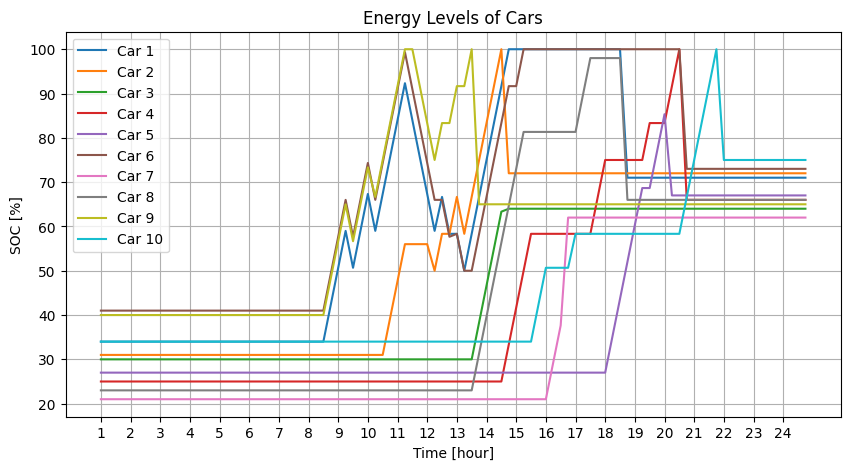

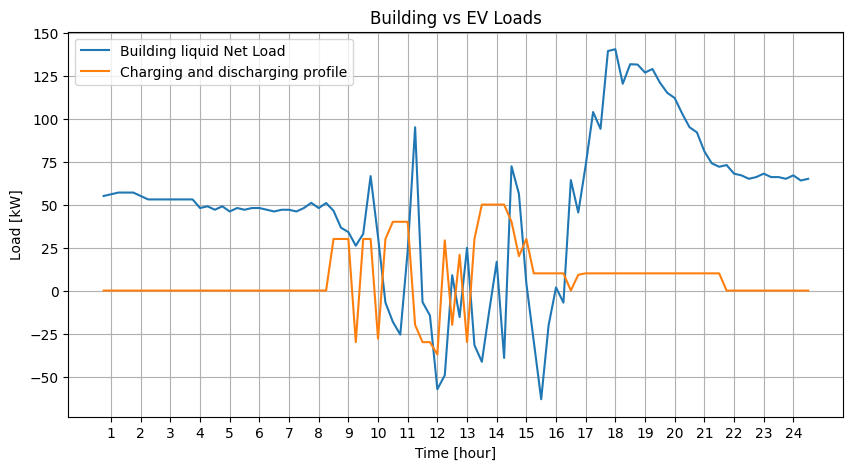

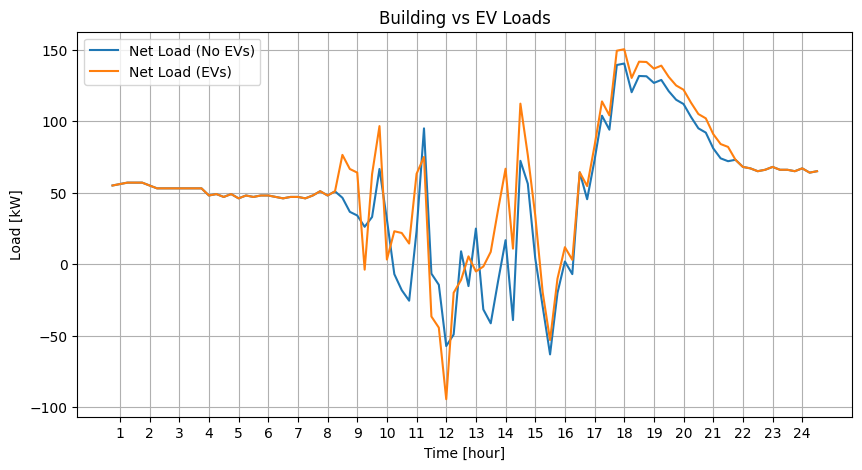

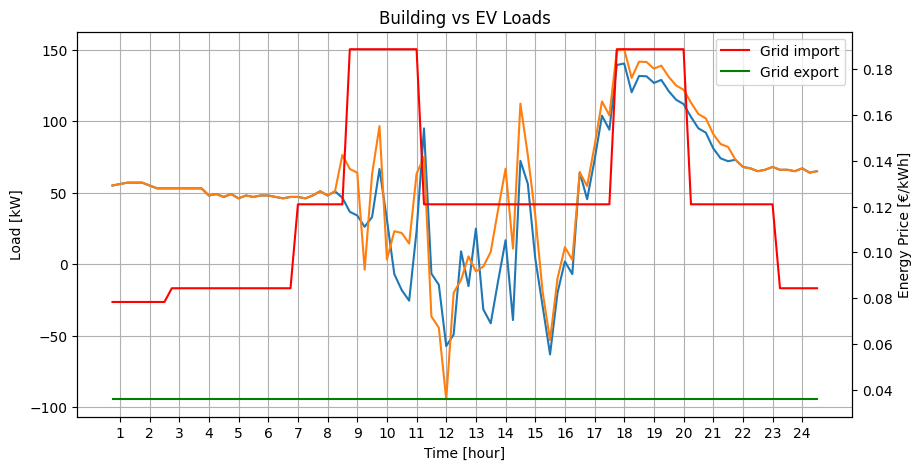

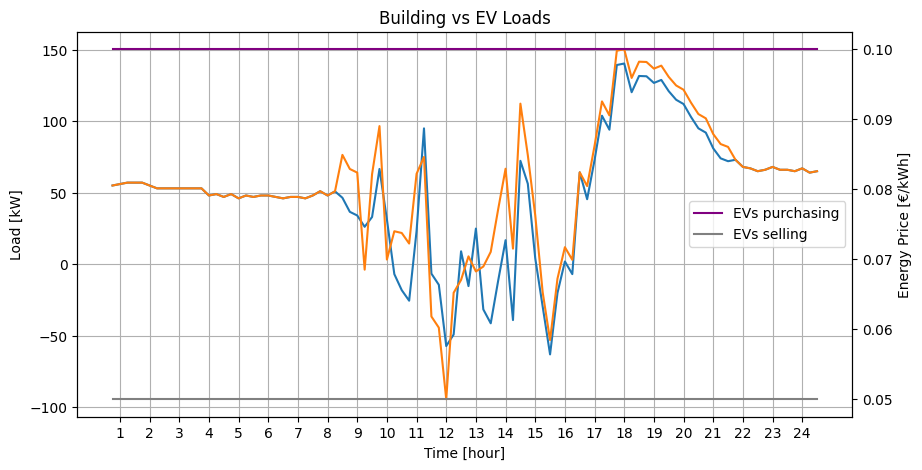

In [9]:
T_values = list(model.T)
I_values = list(model.I)
e_values = (np.array([[model.e_ev[i, t].value for t in model.T] for i in model.I])/E_ev_bat)*100
p_ev_ch_values = np.array([[model.p_ev_ch[i, t].value for t in model.T] for i in model.I])
p_ev_dch_values = np.array([[model.p_ev_dch[i, t].value for t in model.T] for i in model.I])
total_charging_power = np.array([model.alpha[t].value for t in model.T]) # Summing values across all cars for each time step
total_discharging_power = np.array([model.beta[t].value for t in model.T])*-1  # Summing values across all cars for each time step

plot_energy_levels(e_values, model)
plot_total_power(model, P_build)
plot_net_load(model, P_build)
plot_load_and_price(model, P_build, C_grid, C_grid_exp)
plot_transactions_evs_building(model, P_build, C_buy, C_sell)


# Exporting the results to Excel

In [10]:
#Saving the SOC values for each vehicle
ev_soc = pd.DataFrame(e_values)
ev_soc.to_excel('Dados_MO_V13.xlsx')

# Convert matrices to pandas DataFrames
X_df = pd.DataFrame(X_values_matrix, index=I_values, columns=T_values)
Y_df = pd.DataFrame(Y_values_matrix, index=I_values, columns=T_values)
total_charging_df = pd.DataFrame(total_charging_values)
total_discharging_df = pd.DataFrame(total_discharging_values)
C_df = pd.DataFrame(C_values_matrix)
D_df = pd.DataFrame(D_values_matrix)

# Define Excel file names
excel_file_X = "Dados_MO_V13_X_values.xlsx"
excel_file_Y = "Dados_MO_V13_Y_values.xlsx"
excel_file_total_charging = "Dados_MO_V13_Total_charging.xlsx"
excel_file_total_discharging = "Dados_MO_V13_Total_discharging.xlsx"
excel_file_C = "Dados_MO_V13_C_values.xlsx"
excel_file_D = "Dados_MO_V13_D_values.xlsx"

# Write DataFrames to Excel with empty storage options
X_df.to_excel(excel_file_X, sheet_name='X_values', storage_options={})
Y_df.to_excel(excel_file_Y, sheet_name='Y_values', storage_options={})
total_charging_df.to_excel(excel_file_total_charging, sheet_name='Total_Charging', storage_options={})
total_discharging_df.to_excel(excel_file_total_discharging, sheet_name='Total_Discharging', storage_options={})
C_df.to_excel(excel_file_C, sheet_name='C_values', storage_options={})
D_df.to_excel(excel_file_D, sheet_name='D_values', storage_options={})